In [1]:
import sys, string, re, csv, nltk, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
nltk.download('stopwords')
nltk.download('wordnet')

stopwords = nltk.corpus.stopwords.words('english')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_col_list = ['selected_text', 'sentiment']
test_col_list = ['textID', 'text', 'sentiment']
train = pd.read_csv("train.csv", usecols=train_col_list)
test = pd.read_csv("test.csv", usecols=test_col_list)
subm = pd.read_csv("sample_submission.csv")
train.columns = ['body_text', 'label']
test.columns = ['id', 'body_text', 'label']
train.head(10)

,body_text,label
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative
5,http://www.dothebouncy.com/smf - some shameles...,neutral
6,fun,positive
7,Soooo high,neutral
8,Both of you,neutral
9,Wow... u just became cooler.,positive


In [3]:
\


In [4]:
le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])
train.head(50)

,body_text,label
0,"I`d have responded, if I were going",1
1,Sooo SAD,0
2,bullying me,0
3,leave me alone,0
4,"Sons of ****,",0
5,http://www.dothebouncy.com/smf - some shameles...,1
6,fun,2
7,Soooo high,1
8,Both of you,1
9,Wow... u just became cooler.,2


In [5]:
train.isnull().any()

body_text     True
label        False
dtype: bool

In [6]:
dfnull = train[train.isna().any(axis=1)]
dfnull

,body_text,label
314,NaN,1


In [7]:
train = train.dropna(how='any', axis=0)
train

,body_text,label
0,"I`d have responded, if I were going",1
1,Sooo SAD,0
2,bullying me,0
3,leave me alone,0
4,"Sons of ****,",0
5,http://www.dothebouncy.com/smf - some shameles...,1
6,fun,2
7,Soooo high,1
8,Both of you,1
9,Wow... u just became cooler.,2


In [8]:
train.isnull().any()

body_text    False
label        False
dtype: bool

In [9]:
y = train['label']
list_sentences_train = train['body_text']
list_sentences_test = test['body_text']

In [10]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

#Sneak peek into list tokenized training
list_tokenized_train[:1]

[[1, 146, 19, 7030, 73, 1, 157, 46]]

In [11]:
maxlen = 30
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

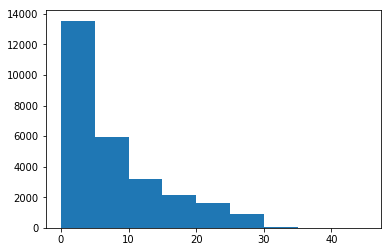

In [12]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords, bins = np.arange(0, 50, 5))
plt.show()

In [13]:
inp = Input(shape=(maxlen, ))

In [14]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [15]:
x = LSTM(20, return_sequences=True, name='lstm_layer')(x)

In [16]:
x = GlobalMaxPool1D()(x)

In [17]:
x = Dropout(0.1)(x)

In [18]:
x = Dense(50, activation='relu')(x)

In [19]:
x = Dropout(0.1)(x)

In [20]:
x = Dense(1, activation='sigmoid')(x)

In [21]:
model = Model(input=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if __name__ == '__main__':


In [22]:
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 24732 samples, validate on 2748 samples
Epoch 1/2
24732/24732 [==============================] - 67s 3ms/step - loss: -24.2570 - accuracy: 0.4252 - val_loss: -88.3117 - val_accuracy: 0.4596
Epoch 2/2
24732/24732 [==============================] - 65s 3ms/step - loss: -327.9824 - accuracy: 0.4937 - val_loss: -481.2246 - val_accuracy: 0.5677


In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 128)           2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 30, 20)            11920     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [24]:
predictions = model.predict(X_te)
predictions

array([[1.        ],
       [1.        ],
       [0.15072611],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [25]:
label_cols = ['selected_text']
submid = pd.DataFrame({'id': subm["textID"]})
submission = pd.concat([submid, pd.DataFrame(predictions, columns = label_cols)], axis=1)
submission.to_csv('Submission-Keras.csv', index=False)
submission

,id,selected_text
0,f87dea47db,1.000000
1,96d74cb729,1.000000
2,eee518ae67,0.150726
3,01082688c6,1.000000
4,33987a8ee5,1.000000
5,726e501993,1.000000
6,261932614e,1.000000
7,afa11da83f,1.000000
8,e64208b4ef,1.000000
9,37bcad24ca,1.000000
